# Setup & Libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import os
import random
import math
from tqdm import tqdm

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(888)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


# Dataset Loading

In [ ]:
# resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [ ]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Data Visualisation

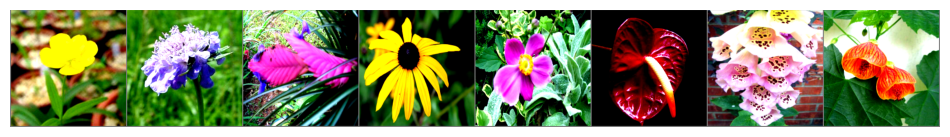

Labels: [47, 21, 92, 62, 61, 79, 93, 96]


In [ ]:
# Class names are available in Flowers102
classes = train_dataset._labels  # Not human-readable, just numeric labels

# func to show images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize (optional)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

# batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 8 random images
plt.figure(figsize=(12, 6))
imshow(torchvision.utils.make_grid(images[:8]))
plt.show()

print("Labels:", labels[:8].tolist())

# Utility Functions

In [ ]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1

            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False

In [ ]:
def val_loop(model, val_loader, criterion, device):
    model.eval()
    total, correct, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    val_loss = running_loss / total
    val_acc = 100.0 * correct / total
    return val_loss, val_acc

def train_model(model,train_loader,val_loader,optimizer,criterion,scheduler=None,epochs=20,
                device=None,early_stopper=None,grad_clip_norm=1.0,best_path="best_vit.pt"):
    model.to(device)
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}
    best_val_loss = math.inf

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, total, correct = 0.0, 0, 0
        history["lr"].append(optimizer.param_groups[0]["lr"])

        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()

            if grad_clip_norm is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)

            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # validation
        val_loss, val_acc = val_loop(model, val_loader, criterion, device)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # scheduler
        if scheduler is not None:
            scheduler.step()

        # save best model
        if (best_path is not None) and (val_loss < best_val_loss):
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

        # ---- Early Stopping ----
        if early_stopper is not None:
            if early_stopper.early_stop(val_loss, model):
                print(f"[Epoch {epoch}] Early stopping. Best val loss: {early_stopper.min_validation_loss:.4f}")
                break

        print(f"[Epoch {epoch:03d}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    final_val_loss, final_val_acc = val_loop(model, val_loader, criterion, device)

    print("\n=== Training Finished ===")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")

    return history

def test_loop(model, test_loader, criterion=None, device=None, load_best=True, best_path="best_vit.pt"):
    model.to(device)
    if load_best:
        model.load_state_dict(torch.load(best_path, map_location=device))

    model.eval()
    total, correct, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            if criterion is not None:
                loss = criterion(outputs, targets)
                running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    acc = 100.0 * correct / total
    msg = f"Test Acc: {acc:.2f}%"
    if criterion is not None:
        test_loss = running_loss / total
        msg += f" | Test Loss: {test_loss:.4f}"
    print(msg)
    return {"test_acc": acc, **({"test_loss": running_loss / total} if criterion else {})}

## 1. Pretrained ViT-B/16 Model

This pretrained ViT-B/16 model was pretrained on ImageNet 1K dataset. In this experiment, it is fine tunned to the Oxford Flowers 102 dataset to establish a transfer learning baseline.



In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.models import vit_b_16, ViT_B_16_Weights


print("Using device:", DEVICE)

# HYPERPARAMETERS
NUM_EPOCH = 20
LR = 3e-4
WEIGHT_DECAY = 0.05
ETA_MIN = 1e-6
MIN_DELTA = 1e-3
PATIENCE = 3
NUM_CLASSES = 102

# model
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
model.heads.head = nn.Linear(in_features=model.heads.head.in_features, out_features=NUM_CLASSES)

# criterion / optimizer / scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCH, eta_min=ETA_MIN)

# early stopper
early_stopper = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA, model_path="best_vit.pt")

# train model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer, #adam
    criterion=criterion, #cross entropy
    scheduler=None,
    epochs=NUM_EPOCH, #20
    device=DEVICE,
    early_stopper=early_stopper,
    grad_clip_norm=1.0,         # or set None to disable
    best_path="best_vit.pt"
)

Using device: cuda
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 208MB/s]


[Epoch 001] Train Loss: 4.5563 | Train Acc: 1.86% | Val Loss: 4.1209 | Val Acc: 6.47% | LR: 0.000300
[Epoch 002] Train Loss: 3.8309 | Train Acc: 7.16% | Val Loss: 3.5494 | Val Acc: 16.18% | LR: 0.000300
[Epoch 003] Train Loss: 3.2832 | Train Acc: 17.25% | Val Loss: 3.2358 | Val Acc: 19.31% | LR: 0.000300
[Epoch 004] Train Loss: 2.8560 | Train Acc: 26.47% | Val Loss: 2.9917 | Val Acc: 25.20% | LR: 0.000300
[Epoch 005] Train Loss: 2.3820 | Train Acc: 34.90% | Val Loss: 2.7411 | Val Acc: 31.57% | LR: 0.000300
[Epoch 006] Train Loss: 1.9495 | Train Acc: 47.75% | Val Loss: 2.6356 | Val Acc: 35.29% | LR: 0.000300
[Epoch 007] Train Loss: 1.5035 | Train Acc: 60.69% | Val Loss: 2.6490 | Val Acc: 34.12% | LR: 0.000300
[Epoch 008] Train Loss: 1.0736 | Train Acc: 73.04% | Val Loss: 2.5031 | Val Acc: 37.16% | LR: 0.000300
[Epoch 009] Train Loss: 0.7165 | Train Acc: 84.41% | Val Loss: 2.5224 | Val Acc: 39.51% | LR: 0.000300
[Epoch 010] Train Loss: 0.4653 | Train Acc: 88.92% | Val Loss: 2.4641 | Val 

In [ ]:
results = test_loop(model, test_loader, criterion=criterion, device=DEVICE, load_best=True)
print(results)

Test Acc: 37.21% | Test Loss: 2.6836
{'test_acc': 37.2093023255814, 'test_loss': 2.6836047473041424}


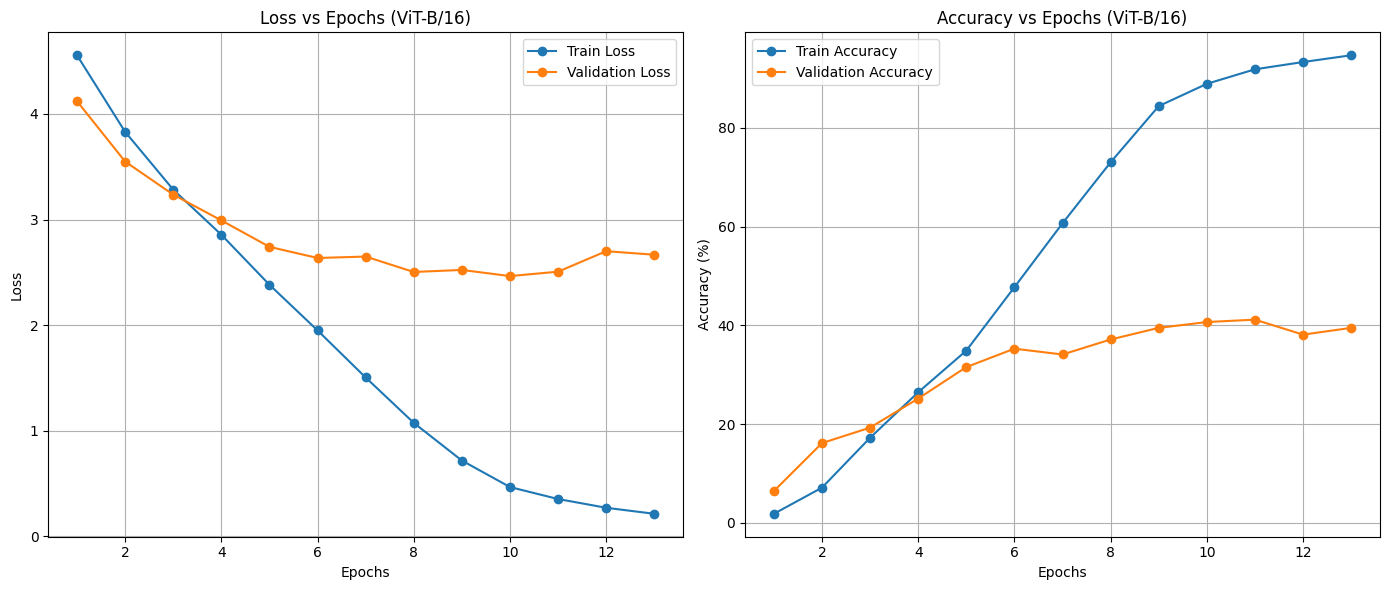

In [ ]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 6))

# ---- Left: Loss vs Epochs ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (ViT-B/16)")
plt.grid(True)
plt.legend()

# ---- Right: Accuracy vs Epochs ----
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs (ViT-B/16)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Hyperparameters Tunning

We focus on the following hyperparameters:
- Fine-tuning strategy
- Learning rate
- Weight decay of Adam Optimizer

In [ ]:
import itertools, time, numpy as np
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights

param_grid = {
    "strategy": ["head_only", "last_block", "full"],
    "lr": [5e-3 ,1e-3, 5e-4, 1e-4],
    "wd": [0.01, 0.05]
}

param_pairs = [
    {"strategy": s, "lr": lr, "wd": wd}
    for (s, lr, wd) in itertools.product(param_grid["strategy"], param_grid["lr"], param_grid["wd"])
]

print(f"Total runs: {len(param_pairs)}")
for p in param_pairs: print(p)

def apply_strategy_freeze(model, strategy: str):
    # reset all trainable
    for p in model.parameters():
        p.requires_grad = True

    if strategy == "head_only":
        for name, p in model.named_parameters():
            p.requires_grad = name.startswith("heads.")
    elif strategy == "last_block":
        # torchvision ViT-B/16 has encoder.layers.0..11 (last block is 11)
        for name, p in model.named_parameters():
            p.requires_grad = name.startswith("encoder.layers.11.") or name.startswith("heads.")
    # "full": leave all True


def run_once(train_loader, val_loader, device, strategy, lr, wd,
             epochs=20, patience=3, min_delta=1e-3, grad_clip_norm=1.0):
    # fresh pretrained model + new head
    model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    model.heads.head = nn.Linear(model.heads.head.in_features, 102)

    apply_strategy_freeze(model, strategy)

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr, weight_decay=wd
    )

    es = EarlyStopper(patience=patience, min_delta=min_delta, verbose=True)

    t0 = time.time()
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=nn.CrossEntropyLoss(),
        scheduler=None,             # fixed LR
        epochs=epochs,
        device=device,
        early_stopper=es,
        grad_clip_norm=grad_clip_norm,
        best_path=None              # IMPORTANT: don't save checkpoints
    )
    secs = round(time.time() - t0, 2)

    val_accs   = history["val_acc"]  if "val_acc"  in history else []
    val_losses = history["val_loss"] if "val_loss" in history else []
    best_val_acc  = float(max(val_accs)) if val_accs else 0.0
    best_epoch    = 1 + int(np.argmax(val_accs)) if val_accs else -1
    best_val_loss = float(min(val_losses)) if val_losses else float("inf")

    return {
        "strategy": strategy,
        "lr": lr,
        "wd": wd,
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "epochs_run": len(val_accs),
        "time_sec": secs,
    }, history


def find_optimal_shared_grid(param_pairs, train_loader, val_loader, device,
                             epochs=20, patience=3, min_delta=1e-3, grad_clip_norm=1.0):
    all_results, best = [], None

    for cfg in param_pairs:
        s, lr, wd = cfg["strategy"], cfg["lr"], cfg["wd"]
        print(f"\n=== Running {s} | LR={lr} | WD={wd} ===")
        result, _ = run_once(train_loader, val_loader, device, s, lr, wd,
                             epochs=epochs, patience=patience, min_delta=min_delta,
                             grad_clip_norm=grad_clip_norm)
        all_results.append(result)

        # pick by highest val acc; tie-break by lower val loss
        if (best is None or
            result["best_val_acc"] > best["best_val_acc"] or
           (result["best_val_acc"] == best["best_val_acc"] and result["best_val_loss"] < best["best_val_loss"])):
            best = result

        print(f"→ Best val acc: {result['best_val_acc']:.2f}% at epoch {result['best_epoch']} "
              f"(val loss {result['best_val_loss']:.4f}) | time {result['time_sec']}s")

    print("\n=== Optimal Hyperparameters (shared LR/WD grid) ===")
    print(f"Strategy: {best['strategy']} | LR: {best['lr']} | WD: {best['wd']}")
    print(f"Best Val Acc: {best['best_val_acc']:.2f}% | Best Val Loss: {best['best_val_loss']:.4f} "
          f"| Epoch: {best['best_epoch']} | Trained Epochs: {best['epochs_run']}")
    return all_results, best


Total runs: 24
{'strategy': 'head_only', 'lr': 0.005, 'wd': 0.01}
{'strategy': 'head_only', 'lr': 0.005, 'wd': 0.05}
{'strategy': 'head_only', 'lr': 0.001, 'wd': 0.01}
{'strategy': 'head_only', 'lr': 0.001, 'wd': 0.05}
{'strategy': 'head_only', 'lr': 0.0005, 'wd': 0.01}
{'strategy': 'head_only', 'lr': 0.0005, 'wd': 0.05}
{'strategy': 'head_only', 'lr': 0.0001, 'wd': 0.01}
{'strategy': 'head_only', 'lr': 0.0001, 'wd': 0.05}
{'strategy': 'last_block', 'lr': 0.005, 'wd': 0.01}
{'strategy': 'last_block', 'lr': 0.005, 'wd': 0.05}
{'strategy': 'last_block', 'lr': 0.001, 'wd': 0.01}
{'strategy': 'last_block', 'lr': 0.001, 'wd': 0.05}
{'strategy': 'last_block', 'lr': 0.0005, 'wd': 0.01}
{'strategy': 'last_block', 'lr': 0.0005, 'wd': 0.05}
{'strategy': 'last_block', 'lr': 0.0001, 'wd': 0.01}
{'strategy': 'last_block', 'lr': 0.0001, 'wd': 0.05}
{'strategy': 'full', 'lr': 0.005, 'wd': 0.01}
{'strategy': 'full', 'lr': 0.005, 'wd': 0.05}
{'strategy': 'full', 'lr': 0.001, 'wd': 0.01}
{'strategy': 'f

In [ ]:
print("Using device: " ,DEVICE)

all_results, best_cfg = find_optimal_shared_grid(
    param_pairs=param_pairs,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=NUM_EPOCH, #20
    patience=PATIENCE, #3
    min_delta=MIN_DELTA, #1e-3
    grad_clip_norm=1.0
)

Using device:  cuda

=== Running head_only | LR=0.005 | WD=0.01 ===
[Epoch 001] Train Loss: 3.2726 | Train Acc: 34.71% | Val Loss: 1.3262 | Val Acc: 69.41% | LR: 0.005000
[Epoch 002] Train Loss: 0.4559 | Train Acc: 90.78% | Val Loss: 0.9123 | Val Acc: 76.37% | LR: 0.005000
[Epoch 003] Train Loss: 0.1244 | Train Acc: 98.24% | Val Loss: 0.7276 | Val Acc: 81.18% | LR: 0.005000
[Epoch 004] Train Loss: 0.0387 | Train Acc: 100.00% | Val Loss: 0.6036 | Val Acc: 84.12% | LR: 0.005000
[Epoch 005] Train Loss: 0.0189 | Train Acc: 99.80% | Val Loss: 0.5539 | Val Acc: 85.59% | LR: 0.005000
[Epoch 006] Train Loss: 0.0126 | Train Acc: 99.80% | Val Loss: 0.5361 | Val Acc: 86.86% | LR: 0.005000
[Epoch 007] Train Loss: 0.0078 | Train Acc: 100.00% | Val Loss: 0.5231 | Val Acc: 86.96% | LR: 0.005000
[Epoch 008] Train Loss: 0.0061 | Train Acc: 100.00% | Val Loss: 0.5163 | Val Acc: 87.25% | LR: 0.005000
[Epoch 009] Train Loss: 0.0052 | Train Acc: 100.00% | Val Loss: 0.5097 | Val Acc: 87.45% | LR: 0.005000
[

## Training of Model with Optimal Hyperparameters

Optimal hyperparameters:
- Strategy: Full
- Learning rate: 0.0001
- Weight Decay: 0.05

In [ ]:
# HYPERPARAMETERS (OPTIMAL and CONSTANT)
STRATEGY     = "full"          # full fine-tune
LR           = 1e-4
WEIGHT_DECAY = 0.05
NUM_EPOCH    = 20
PATIENCE     = 3
MIN_DELTA    = 1e-3
NUM_CLASSES  = 102
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_path = "best_vit_full_lr1e-4_wd0p05.pt"

print("Using device: ", DEVICE)

weights_vit = ViT_B_16_Weights.IMAGENET1K_V1
model_vit = vit_b_16(weights=weights_vit)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, NUM_CLASSES)

for p in model_vit.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model_vit.parameters()),lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA, verbose=True)

history = train_model(
    model=model_vit,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=None,               # fixed LR
    epochs=NUM_EPOCH,
    device=DEVICE,
    early_stopper=early_stopper,
    grad_clip_norm=1.0,
    best_path=best_path
)



Using device:  cuda
[Epoch 001] Train Loss: 4.0684 | Train Acc: 17.94% | Val Loss: 2.8214 | Val Acc: 53.63% | LR: 0.000100
[Epoch 002] Train Loss: 1.7198 | Train Acc: 83.04% | Val Loss: 1.4205 | Val Acc: 85.59% | LR: 0.000100
[Epoch 003] Train Loss: 0.4883 | Train Acc: 99.22% | Val Loss: 0.8389 | Val Acc: 91.18% | LR: 0.000100
[Epoch 004] Train Loss: 0.0958 | Train Acc: 99.90% | Val Loss: 0.5532 | Val Acc: 90.39% | LR: 0.000100
[Epoch 005] Train Loss: 0.0243 | Train Acc: 100.00% | Val Loss: 0.4265 | Val Acc: 92.25% | LR: 0.000100
[Epoch 006] Train Loss: 0.0095 | Train Acc: 100.00% | Val Loss: 0.3766 | Val Acc: 92.45% | LR: 0.000100
[Epoch 007] Train Loss: 0.0059 | Train Acc: 100.00% | Val Loss: 0.3547 | Val Acc: 92.65% | LR: 0.000100
[Epoch 008] Train Loss: 0.0047 | Train Acc: 100.00% | Val Loss: 0.3515 | Val Acc: 92.75% | LR: 0.000100
[Epoch 009] Train Loss: 0.0039 | Train Acc: 100.00% | Val Loss: 0.3468 | Val Acc: 93.04% | LR: 0.000100
[Epoch 010] Train Loss: 0.0034 | Train Acc: 100.

In [ ]:
optimal_hp_vit_history = history
print(optimal_hp_vit_history)

{'train_loss': [4.068391798056808, 1.719810456388137, 0.48827716193947135, 0.09580897013930713, 0.024321711881487976, 0.009462061122644182, 0.005893055616202307, 0.004670239983163044, 0.003921634533132116, 0.0033864047652220025, 0.0029709997742126387, 0.0026393390781081776, 0.002369375172637257, 0.002144386366411459, 0.001955537722153845, 0.0017938208542581575, 0.0016541007591192338, 0.0015322671586866763, 0.0014251403058605158, 0.001329909365021569], 'train_acc': [17.941176470588236, 83.03921568627452, 99.2156862745098, 99.90196078431373, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], 'val_loss': [2.8214146632774204, 1.420492979591968, 0.8389499105659186, 0.5531837791788812, 0.42653185164227203, 0.37656374585394764, 0.3546610513154198, 0.35151454934886855, 0.3468441438441183, 0.34223629329718797, 0.3405649300883798, 0.3383245705389509, 0.3351089583892448, 0.3329206879232444, 0.33158517140968174, 0.3307630032885308, 0.32

In [ ]:
results = test_loop(model_vit, test_loader, criterion=criterion, device=DEVICE, load_best=True, best_path=best_path)
print("Final test results (Optimal Hyperparameters):", results)

Test Acc: 90.24% | Test Loss: 0.4248
Final test results (Optimal Hyperparameters): {'test_acc': 90.24231582371117, 'test_loss': 0.42484744625845505}


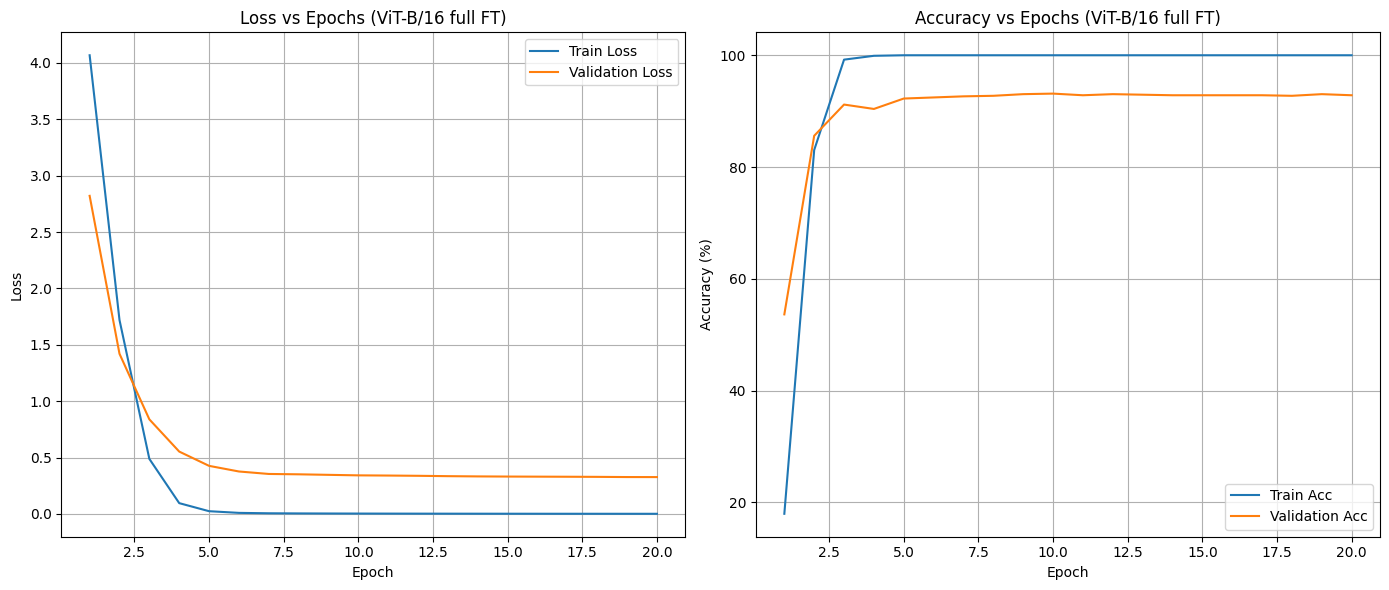

In [ ]:
epochs = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"],   label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epochs (ViT-B/16 full FT)")
plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"],   label="Validation Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy vs Epochs (ViT-B/16 full FT)")
plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()